/var/folders/7w/s6xyt2hj0lg6kkn1nnxbr0sr0000gn/T/ipykernel_69626/2084775442.py:23: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(start=min_date, end=max_date, freq='15T')



Representative Days Analysis (Non-Zero Building Load Only):
- Minimum load day: 2024-02-17 (lowest non-zero building load)
- Maximum load day: 2024-08-30 (highest building load)
- Average load day: 2024-02-14 (closest to non-zero days average)


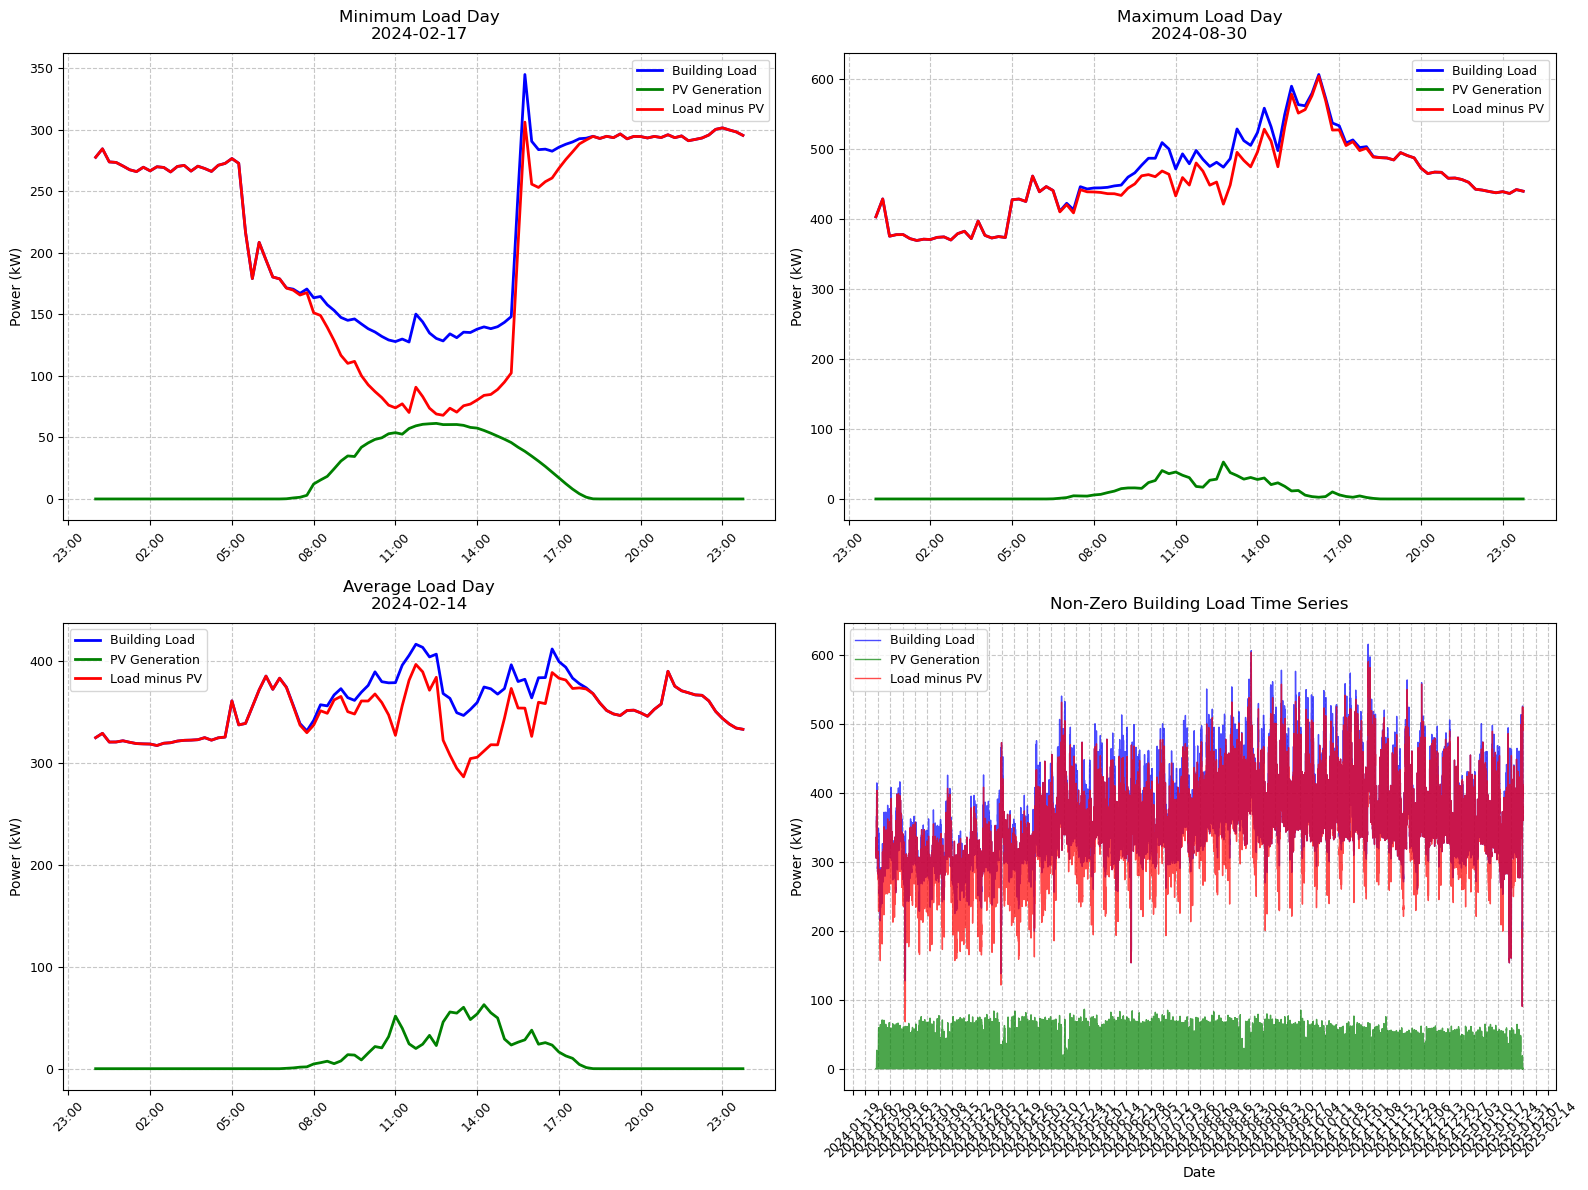

In [25]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# --------------------------
# Data Loading Functions
# --------------------------

def load_csv_data(file_path):
    """Load data from CSV file and parse datetime column"""
    with file_path.open('r') as file:
        df = pd.read_csv(file)
    df['datetime'] = pd.to_datetime(df['datetime'])
    return df.sort_values('datetime')

def merge_datasets(pv_df, meter_df, building_load_col='mean', pv_gen_col='power_avg_kw'):
    """Merge PV and meter data with complete datetime index"""
    # Create complete datetime index
    min_date = min(pv_df['datetime'].min(), meter_df['datetime'].min())
    max_date = max(pv_df['datetime'].max(), meter_df['datetime'].max())
    full_index = pd.date_range(start=min_date, end=max_date, freq='15T')
    
    # Reindex both dataframes
    pv_df = pv_df.set_index('datetime').reindex(full_index, fill_value=0).reset_index().rename(columns={'index': 'datetime'})
    meter_df = meter_df.set_index('datetime').reindex(full_index, fill_value=0).reset_index().rename(columns={'index': 'datetime'})
    
    # Merge and calculate derived columns
    combined_df = pd.merge(meter_df, pv_df, on='datetime', how='outer')
    combined_df['building_load_minus_pv'] = combined_df[building_load_col].fillna(0) - combined_df[pv_gen_col].fillna(0)
    combined_df['date'] = combined_df['datetime'].dt.date
    
    return combined_df, building_load_col, pv_gen_col

# --------------------------
# Analysis Functions
# --------------------------

def calculate_daily_stats(combined_df, building_load_col):
    """Calculate daily statistics for non-zero building load days"""
    non_zero_days = combined_df[combined_df[building_load_col] > 0].groupby('date')
    return non_zero_days.agg({
        building_load_col: 'mean',
        'building_load_minus_pv': 'mean'
    }).reset_index()

def identify_representative_days(daily_stats, building_load_col):
    """Identify min, max, and average representative days"""
    min_day = daily_stats.loc[daily_stats[building_load_col].idxmin(), 'date']
    max_day = daily_stats.loc[daily_stats[building_load_col].idxmax(), 'date']
    
    non_zero_avg = daily_stats[building_load_col].mean()
    avg_day = daily_stats.iloc[
        (daily_stats[building_load_col]-non_zero_avg).abs().argsort()[:1]
    ].iloc[0]['date']
    
    return min_day, max_day, avg_day

# --------------------------
# Plotting Functions
# --------------------------

def create_daily_plot(ax, day_data, title, building_load_col, pv_gen_col):
    """Create a plot for a single representative day"""
    ax.plot(day_data['datetime'], day_data[building_load_col], 
            label='Building Load', color='blue', linewidth=2)
    ax.plot(day_data['datetime'], day_data[pv_gen_col], 
            label='PV Generation', color='green', linewidth=2)
    ax.plot(day_data['datetime'], day_data['building_load_minus_pv'], 
            label='Load minus PV', color='red', linewidth=2)
    
    ax.set_title(title, fontsize=12, pad=10)
    ax.set_ylabel('Power (kW)', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Format time axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
    plt.setp(ax.get_xticklabels(), rotation=45, fontsize=9)
    plt.setp(ax.get_yticklabels(), fontsize=9)

def create_full_timeseries_plot(ax, combined_df, building_load_col, pv_gen_col):
    """Create plot of non-zero building load time series"""
    non_zero_df = combined_df[combined_df[building_load_col] > 0]
    
    ax.plot(non_zero_df['datetime'], non_zero_df[building_load_col], 
            label='Building Load', color='blue', linewidth=1, alpha=0.7)
    ax.plot(non_zero_df['datetime'], non_zero_df[pv_gen_col], 
            label='PV Generation', color='green', linewidth=1, alpha=0.7)
    ax.plot(non_zero_df['datetime'], non_zero_df['building_load_minus_pv'], 
            label='Load minus PV', color='red', linewidth=1, alpha=0.7)
    
    ax.set_title('Non-Zero Building Load Time Series', fontsize=12, pad=10)
    ax.set_ylabel('Power (kW)', fontsize=10)
    ax.set_xlabel('Date', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Format date axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.setp(ax.get_xticklabels(), rotation=45, fontsize=9)
    plt.setp(ax.get_yticklabels(), fontsize=9)

# --------------------------
# Main Workflow
# --------------------------

def analyze_energy_data(pv_path, meter_path):
    """Main analysis workflow"""
    # Load and prepare data
    pv_df = load_csv_data(pv_path)
    meter_df = load_csv_data(meter_path)
    combined_df, building_load_col, pv_gen_col = merge_datasets(pv_df, meter_df)
    
    # Analyze data
    daily_stats = calculate_daily_stats(combined_df, building_load_col)
    min_day, max_day, avg_day = identify_representative_days(daily_stats, building_load_col)
    
    # Print results
    print("\nRepresentative Days Analysis (Non-Zero Building Load Only):")
    print(f"- Minimum load day: {min_day} (lowest non-zero building load)")
    print(f"- Maximum load day: {max_day} (highest building load)")
    print(f"- Average load day: {avg_day} (closest to non-zero days average)")
    
    # Create plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot representative days
    create_daily_plot(ax1, combined_df[combined_df['date'] == min_day], 
                     f"Minimum Load Day\n{min_day}", building_load_col, pv_gen_col)
    create_daily_plot(ax2, combined_df[combined_df['date'] == max_day], 
                     f"Maximum Load Day\n{max_day}", building_load_col, pv_gen_col)
    create_daily_plot(ax3, combined_df[combined_df['date'] == avg_day], 
                     f"Average Load Day\n{avg_day}", building_load_col, pv_gen_col)
    
    # Plot full time series
    create_full_timeseries_plot(ax4, combined_df, building_load_col, pv_gen_col)
    
    plt.tight_layout()
    plt.show()

# --------------------------
# Execution
# --------------------------

if __name__ == "__main__":
    pv_path = Path('life_science_pv.csv')
    meter_path = Path('life_sciences_msb1_main.csv')
    analyze_energy_data(pv_path, meter_path)